In [1]:
import os
#don't use GPU
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal_array
import glob
import random
import pandas as pd
from sklearn import preprocessing

In [3]:
data_drive = r'F:/'

In [4]:
regnie_path = data_drive + r'GruV-Net/data/precipitation/GTiff/'
ground_path = data_drive + r'GruV-Net/data/groundwater_levels_preprocessed_hesse/weekly/'

In [5]:
ground_files_train_paths = glob.glob(ground_path+r'GTiff/'+'2010-*.tif') + glob.glob(ground_path+r'GTiff/'+'2011-*.tif') + glob.glob(ground_path+r'GTiff/'+'2012-*.tif') + glob.glob(ground_path+r'GTiff/'+'2013-*.tif') + glob.glob(ground_path+r'GTiff/'+'2014-*.tif')
ground_files_train_paths.sort()
ground_files_train = list(map(os.path.basename, ground_files_train_paths))

In [6]:
regnie_files_train_paths = glob.glob(regnie_path+'ra10*.tif') + glob.glob(regnie_path+'ra11*.tif') + glob.glob(regnie_path+'ra12*.tif') + glob.glob(regnie_path+'ra13*.tif') + glob.glob(regnie_path+'ra14*.tif')
regnie_files_train_paths.sort()
regnie_files_train = list(map(os.path.basename, regnie_files_train_paths))

In [7]:
ground_files_test_paths = glob.glob(ground_path+r'GTiff/'+'2015-*.tif')
ground_files_test_paths.sort()
ground_files_test = list(map(os.path.basename, ground_files_test_paths))

In [8]:
regnie_files_test_paths = glob.glob(regnie_path+'ra15*.tif')
regnie_files_test_paths.sort()
regnie_files_test = list(map(os.path.basename, regnie_files_test_paths))

möglich normalizer / standardizer:
- MinMax
- MaxAbs
- StandardScaler

In [9]:
def get_random_normalized_samples(n, files, reference_file=None, series_length=1, scaler=None):
    #generates a total of n samples randomly drawn from files
    #if series_lenght > 1, n/series_length randomly drawn time-series of series_length are returned
    #return the samples, the list of drawn dates and the used scaler
    flat = np.ndarray(shape=(n, 35784))
    x_dates = []
    y_dates = []
    if reference_file != None: reference = gdal_array.LoadFile(reference_file).flatten()
    for i in range(0, n, series_length):
        r = random.randrange(0, len(files)-(series_length))
        for j in range(r, r+series_length):
            data = gdal_array.LoadFile(files[j]).flatten()
            #print(files[j])
            if reference_file != None: data = np.subtract(data, reference, where= data!=0.0)
            flat[i+(j-r)] = data
            x_dates.append(os.path.basename(files[j])[:-4])
        y_dates.append(os.path.basename(files[r+series_length])[:-4])
    if scaler == None: scaler = preprocessing.MaxAbsScaler().fit(flat)
    scaled = scaler.transform(flat)
    samples = scaled.reshape(n, 252, 142)
    return samples, x_dates, y_dates, scaler

In [10]:
def get_normalized_regnie_data_by_dates(dates, files, series_length=1, scaler=None):
    #returns the [series_length] data points before each date in dates
    flat = np.ndarray(shape=(len(dates)*series_length, 35784))
    
    for d, i in zip(dates, range(0,len(dates))):
        index = files.index('ra'+d[2:4]+d[5:7]+d[8:10]+'.tif')
        for j in range(index-series_length, index):
            #print(files[j])
            flat[i+(j-(index-series_length))] = gdal_array.LoadFile(regnie_path+files[j]).flatten()

    if scaler == None: scaler = preprocessing.MinMaxScaler().fit(flat)
    scaled = scaler.transform(flat)
    samples = scaled.reshape(len(dates)*series_length, 252, 142)
    return samples, scaler

In [11]:
def get_y_by_dates(dates, ref):
    y = np.ndarray(shape=(len(dates), 1268))
    reference_list =  pd.read_csv(ground_path+r'csv/'+ref+'.csv').fillna(0)['VAL'].to_numpy()
    for i in range(len(dates)):
        temp = pd.read_csv(ground_path+r'csv/'+dates[i]+'.csv').fillna(0)['VAL'].to_numpy()
        y[i] = np.subtract(temp, reference_list)
        #print('y: ', dates[i])
    return y

def assemble_x_instances(ground_data, regnie_data, n, n_ground, n_regnie):
    n_channels = (n_ground*n_regnie)+n_ground
    x = np.ndarray(shape=(n, n_channels, 252, 142))

    ground_index = 0
    regnie_index = 0

    for i in range(n):
        for j in range(n_ground):
            for k in range(n_regnie):
                x[i][j*(n_regnie+1)+k] = regnie_data[regnie_index]
                regnie_index+= 1
            x[i][j*(n_regnie+1)+n_regnie] = ground_data[ground_index]
            ground_index+= 1

    return x

def generate_instances(n_train, n_test, n_ground, n_regnie):
    #generates n_train train instances and n_train validation instances in channels_first order
    #x instances have the shape (n_ground*n_regnie+n_ground, 252, 142) with the pattern (n_regnie*regnie,1*ground)*n_ground
    #y instances are a list of the Groundwater Data at the next date after the last Groundwater Data in the corresponding x

    reference_date = '2010-01-02'
    ground_samples_train, x_dates_train, y_dates_train, ground_scaler = get_random_normalized_samples(n_train*n_ground, ground_files_train_paths, reference_file= ground_path+r'GTiff/'+reference_date+'.tif', series_length=n_ground)
    regnie_data_train, regnie_scaler = get_normalized_regnie_data_by_dates(x_dates_train, regnie_files_train, series_length=n_regnie)
    x_train = assemble_x_instances(ground_samples_train, regnie_data_train, n_train, n_ground, n_regnie)
    y_train = get_y_by_dates(y_dates_train, reference_date)

    ground_samples_test, x_dates_test, y_dates_test, _ = get_random_normalized_samples(n_test*n_ground, ground_files_test_paths, reference_file= ground_path+r'GTiff/'+reference_date+'.tif', series_length=n_ground, scaler= ground_scaler)
    regnie_data_test, _ = get_normalized_regnie_data_by_dates(x_dates_test, regnie_files_test, series_length=n_regnie, scaler=regnie_scaler)
    x_test = assemble_x_instances(ground_samples_test, regnie_data_test, n_test, n_ground, n_regnie)
    y_test = get_y_by_dates(y_dates_test, reference_date)

    return x_train, y_train, x_test, y_test

In [12]:
x_train, y_train, x_test, y_test = generate_instances(1000, 500, 4, 7)

In [13]:
x_train.shape

(1000, 32, 252, 142)

In [14]:
y_train.shape

(1000, 1268)

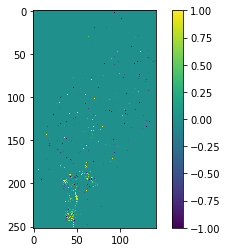

In [15]:
plt.imshow(x_train[560][7])
plt.colorbar()
plt.show()

In [19]:
def create_Simple_2DCNN():
    return tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=5, strides=(5, 5), activation='relu', input_shape=(32, 252, 142), data_format='channels_first'),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(1268)
])
GruV_Net_Simple_2DCNN = create_Simple_2DCNN()
GruV_Net_Simple_2DCNN.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
GruV_Net_Simple_2DCNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 50, 28)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 16, 28)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4480)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              9177088   
_________________________________________________________________
dense_3 (Dense)              (None, 1268)              2598132   
Total params: 11,800,852
Trainable params: 11,800,852
Non-trainable params: 0
_________________________________________________________________


In [20]:
hist = GruV_Net_Simple_2DCNN.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=10)

Train on 1000 samples, validate on 500 samples
Epoch 1/10
1000/1000 [==============================] - 15s 15ms/sample - loss: 1929.7045 - mean_absolute_error: 12.2483 - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/10
1000/1000 [==============================] - 18s 18ms/sample - loss: 1171.4790 - mean_absolute_error: 9.6496 - val_loss: nan - val_mean_absolute_error: nan
Epoch 3/10
1000/1000 [==============================] - 19s 19ms/sample - loss: 879.1079 - mean_absolute_error: 8.1243 - val_loss: nan - val_mean_absolute_error: nan
Epoch 4/10
1000/1000 [==============================] - 14s 14ms/sample - loss: 771.1754 - mean_absolute_error: 7.4236 - val_loss: nan - val_mean_absolute_error: nan
Epoch 5/10
1000/1000 [==============================] - 16s 16ms/sample - loss: 729.3722 - mean_absolute_error: 7.0868 - val_loss: nan - val_mean_absolute_error: nan
Epoch 6/10
1000/1000 [==============================] - 18s 18ms/sample - loss: 698.6526 - mean_absolute_error: 6.8913 -

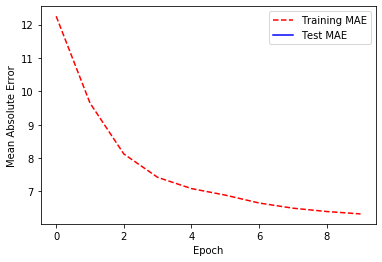

In [21]:
training_mae = hist.history['mean_absolute_error']
test_mae = hist.history['val_mean_absolute_error']

plt.plot(training_mae, 'r--')
plt.plot(test_mae, 'b-')
plt.legend(['Training MAE', 'Test MAE'])
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.show()